In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from utils.visualizer import Visualizer
from IPython.display import SVG, display
from sklearn.metrics import precision_recall_curve

import numpy as np
import matplotlib.pyplot as plt

import os
import time
import pickle
import sklearn
import lasagne
import itertools

plt.style.use('ggplot')

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [4]:
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt].astype(np.float32), targets[excerpt].astype(np.float32)


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2].astype(np.float32), y_val[:2].astype(np.float32))
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()

# Build the dataset

In [ ]:
JPEG_FOLDER = '../data/VOCdevkit/VOC2012/JPEGImages'
ims = []

for fname in os.listdir(JPEG_FOLDER):
    ims.append(plt.imread(os.path.join(JPEG_FOLDER, fname)))

In [ ]:
import scipy as sp

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def crop(img):    
    img = rgb2gray(img)
    
    if img.shape[0] > img.shape[1]:
        img = sp.ndimage.rotate(img, 90)
        
    return sp.misc.imresize(img, [350, 500])

In [ ]:
base = np.asarray(map(crop, ims))

In [ ]:
with open('../data/mnist.pkl') as f:
    dataset = pickle.load(f)

In [ ]:
train = dataset[0][0].reshape(-1, 28, 28)
val = dataset[1][0].reshape(-1, 28, 28)
test = dataset[2][0].reshape(-1, 28, 28)

In [ ]:
i = X_y[1][0].reshape(350, 500)
plt.imshow(i, cmap=plt.cm.Greys_r)
plt.imsave('../im1.png', i, cmap=plt.cm.Greys_r)

In [ ]:
digits = (np.vstack([train, val, test]) * 255).astype(np.uint8)

In [ ]:
train_labels = dataset[0][1]
val_labels = dataset[1][1]
test_labels = dataset[2][1]

In [ ]:
labels = np.hstack([train_labels, val_labels, test_labels])

In [ ]:
import itertools

cells = list(itertools.product(range(350 / 40), range(500 / 40)))

In [ ]:
def add_digits(img, digits, labels, target, size):
    pad_idxs = np.random.choice(range(len(cells)), size=size, replace=False)
    tmp = img.copy()
    answer = np.zeros_like(img)

    for i in range(size):
        x, y = np.array(cells[pad_idxs[i]]) * 40
        digit_idx = np.random.choice(digits.shape[0])
        label = labels[digit_idx]
        tmp2 = sp.ndimage.rotate(digits[digit_idx], np.random.randint(360))
        tmp2[tmp2 <= 0.5 * 255] = 0
        tmp2[tmp2 > 0.5 * 255] = 255

        tmp2[tmp2 >= 255*0.5] = 255
        tmp2[tmp2 < 255*0.5] = 0

        blured = sp.ndimage.gaussian_filter(tmp2, sigma=0.5)

        tmp2 = blured.astype(np.int64) - tmp2.astype(np.int64)

        tmp22 = np.zeros_like(tmp2)

        tmp22[tmp2 >= 0] = (tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]].mean() + 128) % 256
        tmp22[tmp2 < 0] = tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]].mean()
        tmp22[tmp2 == 0] = tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]][tmp2 == 0]

        tmp[x:x + tmp2.shape[0], y:y + tmp2.shape[1]] = tmp22
        
        if label == target:
            answer[x:x + tmp2.shape[0], y:y + tmp2.shape[1]] = 1
        
    return tmp, answer
   
size = 10
target = 7
plt.figure(figsize=(10,10))
plt.imshow(add_digits(base[10050], digits, labels, target, size)[0], cmap=plt.cm.Greys_r)
plt.grid('off')

In [ ]:
dataset = []
targets = []
target = 7
size = 10

for img in base:
    new_img, answer = add_digits(img, digits, labels, target, size)
    dataset.append(new_img)
    targets.append(answer)

In [ ]:
dataset = np.asarray(dataset)
targets = np.asarray(targets)

In [5]:
dataset = np.load('../data/artificial_dataset1.npy')
targets = np.load('../data/artificial_dataset1_targets.npy')

In [ ]:
np.save('../data/artificial_dataset1', dataset)

In [ ]:
np.save('../data/artificial_dataset1_targets', targets)

In [10]:
# cascade_builder(input_layer, num_filters, filter_size, pool_size)
# num_filters
# filter_size
# pool_size
#
# Returns: cascade, complaxity
def cascade_builder(input_layer, num_filters, filter_size, pool_size, name):
    cascade0 = lasagne.layers.Conv2DLayer(input_layer,
                                          num_filters=num_filters,
                                          filter_size=filter_size,
                                          nonlinearity=lasagne.nonlinearities.elu,
                                          pad='same',
                                          name='conv_l_' + name)
#     cascade1 = lasagne.layers.Conv2DLayer(cascade0,
#                                           num_filters=num_filters,
#                                           filter_size=filter_size,
#                                           nonlinearity=lasagne.nonlinearities.elu,
#                                           pad='same')
    cascade = lasagne.layers.MaxPool2DLayer(cascade0, pool_size=pool_size, name = 'MaxPool_l_' + name)
    
    complexity = np.prod(cascade0.filter_size) * cascade0.num_filters
    
    return cascade, complexity

In [16]:
from models.buldozer import Buldozer

In [7]:
# params = ((4, 3, 4),
#           (8, 3, 2), 
#           (16, 3, 2),
#           (32, 3, 2),
#           (64, 3, 2))
# buldozer = Buldozer(
#                     [cascade_builder] * 5,
#                     params,
#                     img_shape    = (350, 500),
#                     c_sub_objs   = [1e-0, 0.0, 0.0, 0.0, 0.0],
#                     c_sub_obj_cs = [1e-1, 0.0, 0.0, 0.0, 0.0],
#                     c_complexity=0.0001,
#                     c_obj=1
#                    )

In [6]:
X_y = train_test_split(dataset.reshape(-1, 1, 350, 500), targets.reshape(-1, 1, 350, 500), random_state=42)

In [ ]:
params = [[4, 3, 4]]
buldozer = Buldozer(
                    [cascade_builder] * 1,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [1e-0],
                    c_sub_obj_cs = [1e-3],
                    c_complexity=0.0
                   )

<IPython.core.display.Javascript object>


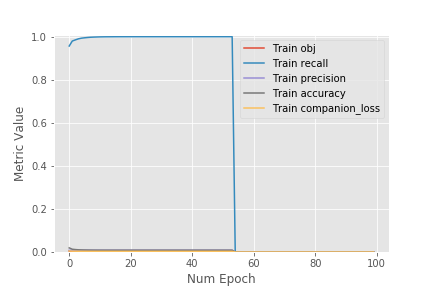

<IPython.core.display.Javascript object>


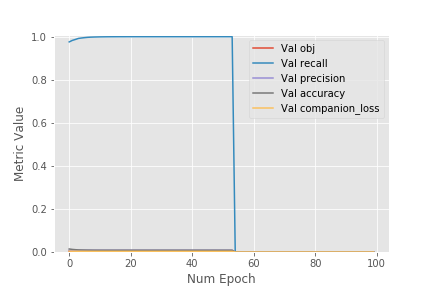

<IPython.core.display.Javascript object>


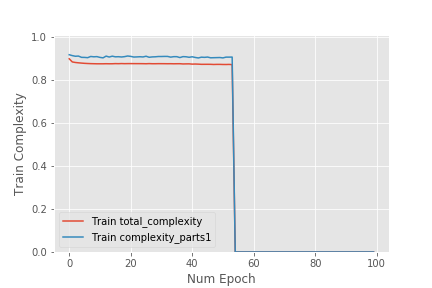

<IPython.core.display.Javascript object>


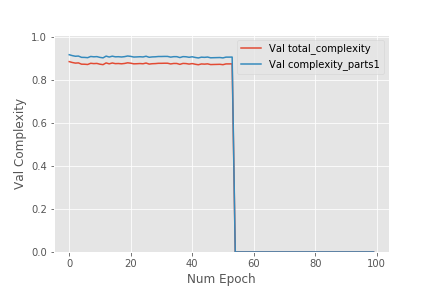

Epoch 1 of 100 took 43.530s
Epoch 2 of 100 took 46.236s
Epoch 3 of 100 took 46.574s
Epoch 4 of 100 took 45.677s
Epoch 5 of 100 took 44.084s
Epoch 6 of 100 took 44.048s
Epoch 7 of 100 took 44.491s
Epoch 8 of 100 took 46.363s
Epoch 9 of 100 took 44.501s
Epoch 10 of 100 took 44.690s
Epoch 11 of 100 took 45.512s
Epoch 12 of 100 took 44.862s
Epoch 13 of 100 took 45.093s
Epoch 14 of 100 took 45.577s
Epoch 15 of 100 took 45.473s
Epoch 16 of 100 took 46.013s
Epoch 17 of 100 took 46.691s
Epoch 18 of 100 took 45.460s
Epoch 19 of 100 took 45.862s
Epoch 20 of 100 took 46.019s
Epoch 21 of 100 took 45.843s
Epoch 22 of 100 took 45.622s
Epoch 23 of 100 took 45.663s
Epoch 24 of 100 took 46.061s
Epoch 25 of 100 took 45.956s
Epoch 26 of 100 took 45.376s
Epoch 27 of 100 took 45.544s
Epoch 28 of 100 took 46.393s
Epoch 29 of 100 took 45.555s
Epoch 30 of 100 took 45.550s
Epoch 31 of 100 took 45.626s
Epoch 32 of 100 took 46.382s
Epoch 33 of 100 took 45.863s
Epoch 34 of 100 took 46.313s
Epoch 35 of 100 took 46

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


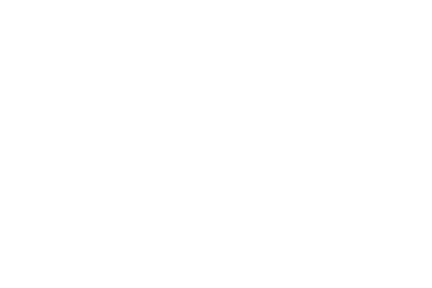

<IPython.core.display.Javascript object>


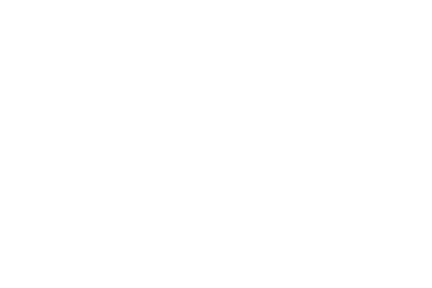

<IPython.core.display.Javascript object>


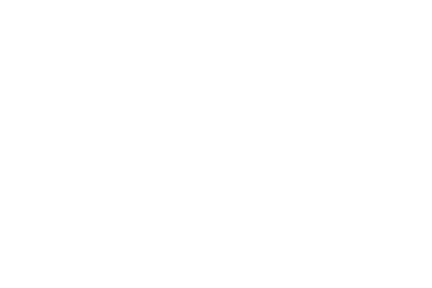

<IPython.core.display.Javascript object>


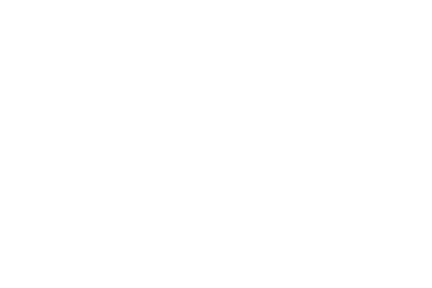

In [ ]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy',
               'companion_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=100, batch_size=150
)

In [ ]:
buldozer.save('../weights', 'buldozer_pre_1')

In [67]:
params = ((4, 3, 4),
          (8, 3, 2))
buldozer = Buldozer(
                    [cascade_builder] * 2,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [0.0, 1e-0],
                    c_sub_obj_cs = [0.0, 1e-1],
                    c_complexity=1e-3
                   )

In [68]:
with np.load(os.path.join('../weights', 'buldozer_pre_1' + '.npz')) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

In [ ]:
lasagne.layers.set_all_param_values(lasagne.layers.get_all_layers(buldozer.output_layer)[3], param_values)

<IPython.core.display.Javascript object>


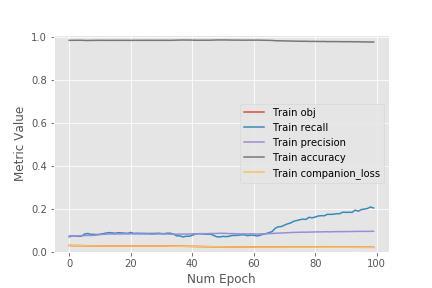

<IPython.core.display.Javascript object>


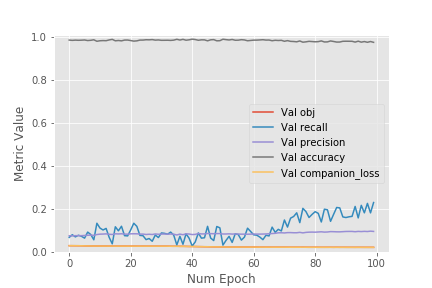

<IPython.core.display.Javascript object>


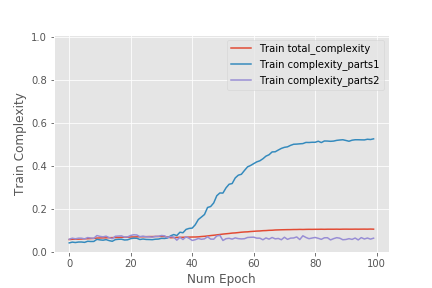

<IPython.core.display.Javascript object>


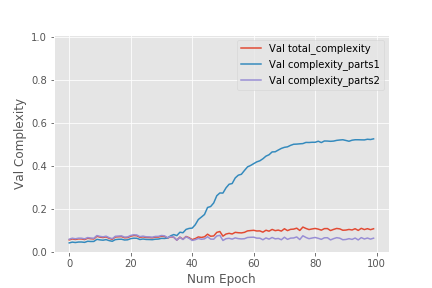

Epoch 1 of 100 took 66.407s
Epoch 2 of 100 took 66.706s
Epoch 3 of 100 took 65.915s
Epoch 4 of 100 took 65.266s
Epoch 5 of 100 took 66.224s
Epoch 6 of 100 took 66.505s
Epoch 7 of 100 took 66.019s
Epoch 8 of 100 took 66.095s
Epoch 9 of 100 took 65.368s
Epoch 10 of 100 took 67.685s
Epoch 11 of 100 took 67.499s
Epoch 11 of 100 took 67.499s
Epoch 12 of 100 took 67.346s
Epoch 12 of 100 took 67.346s
Epoch 13 of 100 took 66.606s
Epoch 13 of 100 took 66.606s
Epoch 14 of 100 took 67.050s
Epoch 14 of 100 took 67.050s
Epoch 15 of 100 took 67.044s
Epoch 15 of 100 took 67.044s
Epoch 16 of 100 took 66.684s
Epoch 16 of 100 took 66.684s
Epoch 17 of 100 took 66.620s
Epoch 17 of 100 took 66.620s
Epoch 18 of 100 took 66.916s
Epoch 18 of 100 took 66.916s
Epoch 19 of 100 took 66.757s
Epoch 19 of 100 took 66.757s
Epoch 20 of 100 took 66.789s
Epoch 20 of 100 took 66.789s
Epoch 21 of 100 took 67.281s
Epoch 21 of 100 took 67.281s
Epoch 22 of 100 took 67.349s
Epoch 22 of 100 took 67.349s
Epoch 23 of 100 took 66

In [ ]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy',
               'companion_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=100, batch_size=150
)

In [72]:
buldozer.save('../weights', 'buldozer_pre_2')

In [74]:
with np.load(os.path.join('../weights', 'buldozer_pre_2' + '.npz')) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

In [75]:
params = ((4, 3, 4),
          (8, 3, 2), 
          (16, 3, 2))
buldozer = Buldozer(
                    [cascade_builder] * 3,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [0.0, 0.0, 1e-0],
                    c_sub_obj_cs = [0.0, 0.0, 1e-1],
                    c_complexity=1e-3
                   )

In [77]:
lasagne.layers.set_all_param_values(lasagne.layers.get_all_layers(buldozer.output_layer)[9], param_values)

<IPython.core.display.Javascript object>


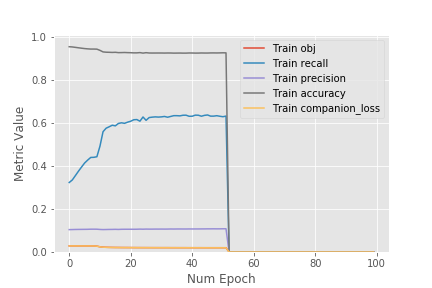

<IPython.core.display.Javascript object>


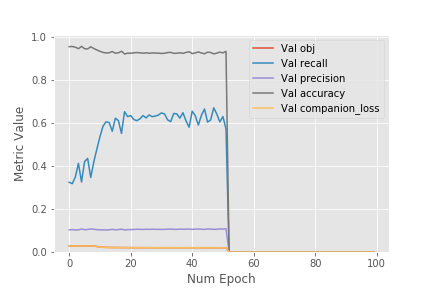

<IPython.core.display.Javascript object>


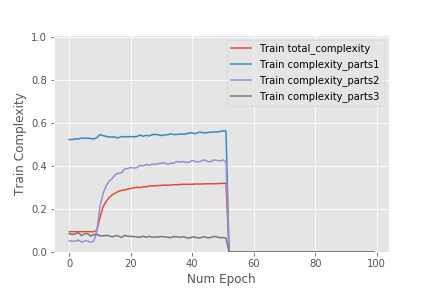

<IPython.core.display.Javascript object>


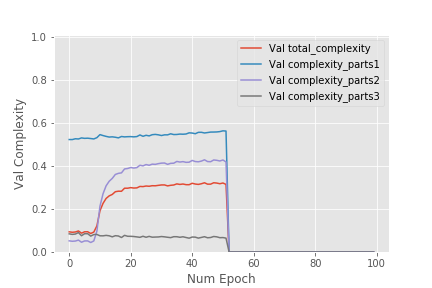

Epoch 1 of 100 took 93.461s
Epoch 2 of 100 took 94.479s
Epoch 3 of 100 took 94.711s
Epoch 4 of 100 took 94.658s
Epoch 5 of 100 took 94.619s
Epoch 6 of 100 took 94.913s
Epoch 7 of 100 took 94.556s
Epoch 8 of 100 took 94.636s
Epoch 9 of 100 took 94.211s
Epoch 10 of 100 took 93.917s
Epoch 11 of 100 took 94.453s
Epoch 12 of 100 took 93.966s
Epoch 13 of 100 took 94.616s
Epoch 14 of 100 took 94.721s
Epoch 15 of 100 took 94.867s
Epoch 16 of 100 took 94.694s
Epoch 17 of 100 took 94.638s
Epoch 18 of 100 took 94.752s
Epoch 19 of 100 took 94.755s
Epoch 20 of 100 took 94.894s
Epoch 21 of 100 took 94.751s
Epoch 22 of 100 took 94.822s
Epoch 23 of 100 took 94.719s
Epoch 24 of 100 took 94.926s
Epoch 25 of 100 took 94.683s
Epoch 26 of 100 took 94.082s
Epoch 27 of 100 took 94.316s
Epoch 28 of 100 took 94.128s
Epoch 29 of 100 took 94.153s
Epoch 30 of 100 took 94.347s
Epoch 31 of 100 took 94.520s
Epoch 32 of 100 took 94.670s
Epoch 33 of 100 took 94.523s
Epoch 34 of 100 took 94.553s
Epoch 35 of 100 took 94

In [ ]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy',
               'companion_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=100, batch_size=100
)

In [84]:
buldozer.save('../weights', 'buldozer_pre_3')

In [93]:
params = ((4, 3, 4),
          (8, 3, 2), 
          (16, 3, 2),
          (32, 3, 2))
buldozer = Buldozer(
                    [cascade_builder] * 4,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [0.0, 0.0, 0.0, 1e-0],
                    c_sub_obj_cs = [0.0, 0.0, 0.0, 1e-1],
                    c_complexity=1e-3
                   )

In [94]:
with np.load(os.path.join('../weights', 'buldozer_pre_3' + '.npz')) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

In [97]:
lasagne.layers.set_all_param_values(lasagne.layers.get_all_layers(buldozer.output_layer)[14], param_values)

<IPython.core.display.Javascript object>


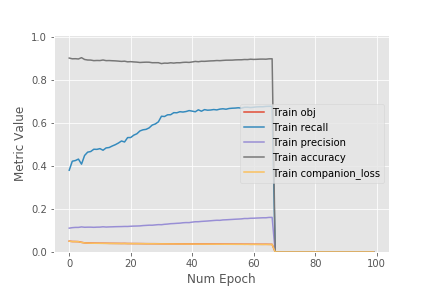

<IPython.core.display.Javascript object>


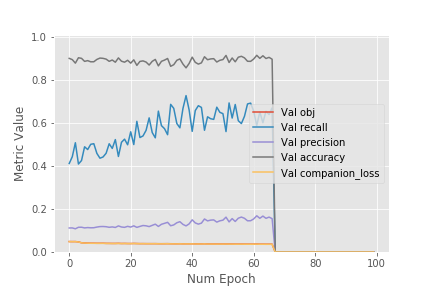

<IPython.core.display.Javascript object>


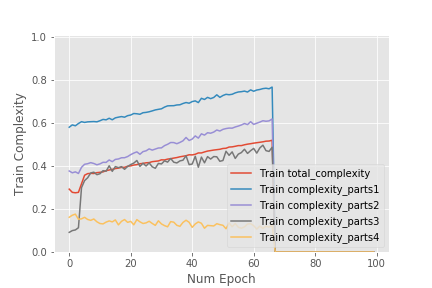

<IPython.core.display.Javascript object>


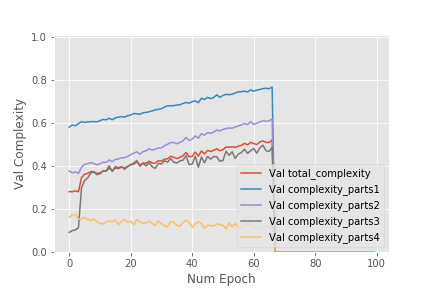

Epoch 1 of 100 took 119.652s
Epoch 2 of 100 took 119.946s
Epoch 3 of 100 took 120.009s
Epoch 4 of 100 took 119.327s
Epoch 5 of 100 took 119.706s
Epoch 6 of 100 took 120.329s
Epoch 7 of 100 took 120.158s
Epoch 8 of 100 took 120.859s
Epoch 9 of 100 took 120.383s
Epoch 10 of 100 took 120.472s
Epoch 11 of 100 took 120.384s
Epoch 12 of 100 took 120.303s
Epoch 13 of 100 took 119.788s
Epoch 14 of 100 took 120.357s
Epoch 15 of 100 took 119.778s
Epoch 16 of 100 took 119.996s
Epoch 17 of 100 took 120.010s
Epoch 18 of 100 took 119.996s
Epoch 19 of 100 took 120.406s
Epoch 20 of 100 took 120.233s
Epoch 21 of 100 took 120.121s
Epoch 22 of 100 took 120.135s
Epoch 23 of 100 took 120.433s
Epoch 24 of 100 took 120.278s
Epoch 25 of 100 took 120.154s
Epoch 26 of 100 took 119.837s
Epoch 27 of 100 took 120.129s
Epoch 28 of 100 took 120.187s
Epoch 29 of 100 took 120.634s
Epoch 30 of 100 took 120.591s
Epoch 31 of 100 took 120.102s
Epoch 32 of 100 took 120.443s
Epoch 33 of 100 took 120.056s
Epoch 34 of 100 too

In [ ]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy',
               'companion_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=100, batch_size=100
)

In [100]:
buldozer.save('../weights', 'buldozer_pre_4')

In [102]:
params = ((4, 3, 4),
          (8, 3, 2), 
          (16, 3, 2),
          (32, 3, 2),
          (64, 3, 2)
         )
buldozer = Buldozer(
                    [cascade_builder] * 5,
                    params,
                    img_shape    = (350, 500),
                    c_sub_objs   = [0.0, 0.0, 0.0, 0.0, 1e-0],
                    c_sub_obj_cs = [0.0, 0.0, 0.0, 0.0, 1e-1],
                    c_complexity=1e-3
                   )

In [103]:
with np.load(os.path.join('../weights', 'buldozer_pre_4' + '.npz')) as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]

In [112]:
lasagne.layers.set_all_param_values(lasagne.layers.get_all_layers(buldozer.output_layer)[18], param_values)

In [115]:
# for j, i in enumerate(lasagne.layers.get_all_layers(buldozer.output_layer)):
#     print j, i.name

<IPython.core.display.Javascript object>


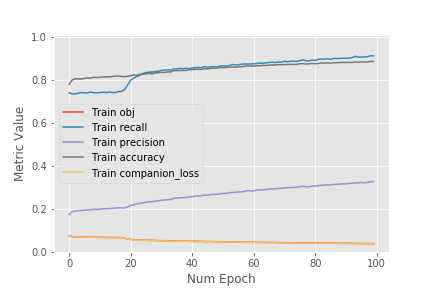

<IPython.core.display.Javascript object>


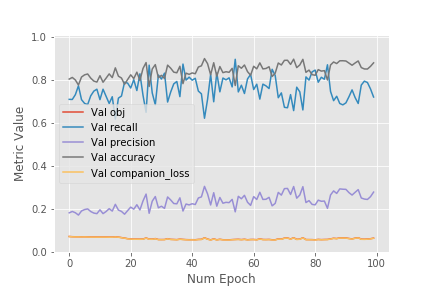

<IPython.core.display.Javascript object>


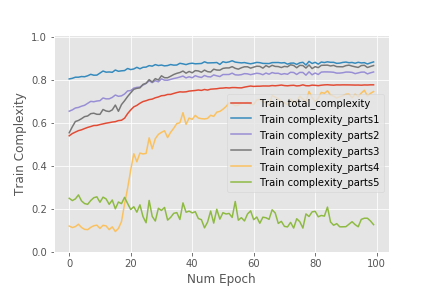

<IPython.core.display.Javascript object>


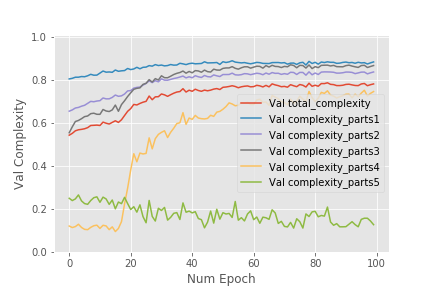

Epoch 1 of 100 took 142.543s
Epoch 2 of 100 took 143.980s
Epoch 3 of 100 took 142.771s
Epoch 4 of 100 took 143.729s
Epoch 5 of 100 took 144.606s
Epoch 6 of 100 took 143.335s
Epoch 7 of 100 took 144.944s
Epoch 8 of 100 took 143.541s
Epoch 9 of 100 took 143.289s
Epoch 10 of 100 took 143.493s
Epoch 11 of 100 took 143.958s
Epoch 12 of 100 took 145.042s
Epoch 13 of 100 took 144.724s
Epoch 14 of 100 took 145.682s
Epoch 15 of 100 took 143.643s
Epoch 16 of 100 took 145.286s
Epoch 17 of 100 took 144.140s
Epoch 18 of 100 took 144.567s
Epoch 19 of 100 took 144.921s
Epoch 20 of 100 took 145.441s
Epoch 21 of 100 took 144.301s
Epoch 22 of 100 took 143.355s
Epoch 23 of 100 took 142.812s
Epoch 24 of 100 took 143.198s
Epoch 25 of 100 took 144.301s
Epoch 26 of 100 took 143.529s
Epoch 27 of 100 took 144.579s
Epoch 28 of 100 took 145.262s
Epoch 29 of 100 took 144.933s
Epoch 30 of 100 took 145.103s
Epoch 31 of 100 took 144.118s
Epoch 32 of 100 took 143.089s
Epoch 33 of 100 took 144.919s
Epoch 34 of 100 too

In [116]:
learn(buldozer,
      X_y,
      watches=['obj',
               'recall', 
               'precision', 
               'accuracy',
               'companion_loss',
               'total_complexity', 
               'complexity_parts'],
      num_epochs=100, batch_size=100
)

In [ ]:
buldozer.evaluate(X_y[1][:100], X_y[-1][:100])

In [91]:
import theano

companions =  [theano.function([buldozer.input_X],
                               lasagne.layers.get_output(buldozer.downsampled_activation_layers[i]))
                               for i in range(len(buldozer.downsampled_activation_layers))]

def draw_precision_recall(prediction, target):
    precision, recall, thr = precision_recall_curve(target.ravel(), prediction.ravel())

    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.plot(np.arange(thr.shape[0]) / (thr.shape[0] + 1e-6), thr, label='Threshold')
    plt.xlabel('Recall')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc='best')
    plt.show()
    
    for r in [0.90, 0.95, 0.99, 0.999]:
        print 'Recall:', recall[np.max(np.where(recall >= r))]
        print 'Precision:', precision[np.max(np.where(recall >= r))]
        print

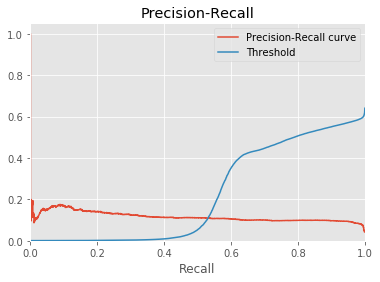

Recall: 0.901047729919
Precision: 0.0969196093163

Recall: 0.951105937136
Precision: 0.0934141321747

Recall: 0.990686845169
Precision: 0.0785997968043

Recall: 1.0
Precision: 0.0424344217754



In [92]:
%matplotlib inline

get_target = theano.function([buldozer.targets], lasagne.layers.get_output(buldozer.target_pool_layers[-1]))

prediction = buldozer.predict(X_y[1][:100]).ravel()
target = get_target(X_y[-1][:100]).ravel()

draw_precision_recall(prediction, target)

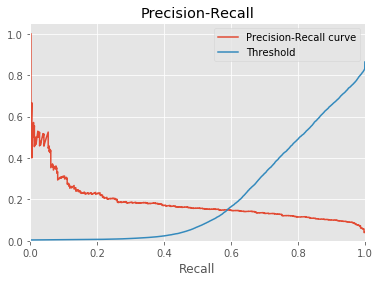

Recall: 0.90206185567
Precision: 0.100200400802

Recall: 0.951030927835
Precision: 0.0908643191332

Recall: 0.992268041237
Precision: 0.0614329025052

Recall: 1.0
Precision: 0.040153161544



In [99]:
%matplotlib inline

get_target = theano.function([buldozer.targets], lasagne.layers.get_output(buldozer.target_pool_layers[-1]))

prediction = buldozer.predict(X_y[1][:100]).ravel()
target = get_target(X_y[-1][:100]).ravel()

draw_precision_recall(prediction, target)

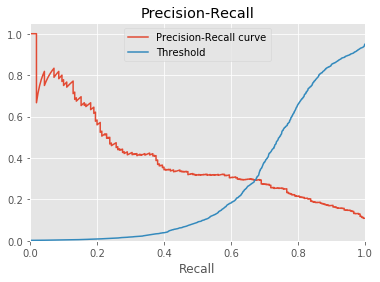

Recall: 0.9
Precision: 0.17042380523

Recall: 0.952380952381
Precision: 0.147601476015

Recall: 0.990476190476
Precision: 0.118249005117

Recall: 1.0
Precision: 0.108864696734



In [117]:
%matplotlib inline

get_target = theano.function([buldozer.targets], lasagne.layers.get_output(buldozer.target_pool_layers[-1]))

prediction = buldozer.predict(X_y[1][:100]).ravel()
target = get_target(X_y[-1][:100]).ravel()

draw_precision_recall(prediction, target)

In [ ]:
%matplotlib inline
draw_precision_recall(buldozer, X_y[1][:100], X_y[-1][:100])

In [ ]:
%matplotlib inline
draw_precision_recall(buldozer, X_y[1][:100], X_y[-1][:100])

In [ ]:
X_y[1][:100].shape

In [ ]:
X_y[-1][:100].shape

In [ ]:
print 1